<a href="https://colab.research.google.com/github/HegdeSiddesh/cs6910_Assignment2/blob/main/Part%20A/Part_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CS6910 Assignment 2 Part A: 
The goal of this part is as follows:        
- Train a CNN model from scratch and learn how to tune the hyperparameters and visualise filters      



### Import required packages

In [4]:
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import random
np.random.seed(137) # To ensure that the random number generated are the same for every iteration
import warnings
!pip install --upgrade wandb
import wandb
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from keras.models import Sequential
from keras_preprocessing.image import ImageDataGenerator
import os
from keras.datasets import fashion_mnist
from keras.layers.convolutional import Conv2D
from keras.layers import Dense, Flatten, InputLayer
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Activation
from wandb.keras import WandbCallback
from google.colab.patches import cv2_imshow
tf.random.set_seed(137)

In [2]:
wandb.login()

wandb: Currently logged in as: hithesh-sidhesh (use `wandb login --relogin` to force relogin)


True

In [2]:
#Download and unzip the iNaturalist dataset
!wget https://storage.googleapis.com/wandb_datasets/nature_12K.zip
!unzip -q /content/nature_12K.zip

--2022-03-31 04:45:08--  https://storage.googleapis.com/wandb_datasets/nature_12K.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.145.128, 74.125.128.128, 173.194.69.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.145.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3816687935 (3.6G) [application/zip]
Saving to: ‘nature_12K.zip’

nature_12K.zip      100%[===================>]   3.55G  75.9MB/s    in 41s     

2022-03-31 04:45:50 (88.9 MB/s) - ‘nature_12K.zip’ saved [3816687935/3816687935]



##Question 1 

Build a small CNN model consisting of  5 convolution layers. Each convolution layer would be followed by a ReLU activation and a max pooling layer. 

After 5 such conv-relu-maxpool blocks of  layers you should have one dense layer followed by the output layer containing 10 neurons (1 for each of the 10 classes).    

The input layer should be compatible with the images in the iNaturalist dataset.
The code should be flexible such that the number of filters, size of filters and activation function in each layer can be changed. You should also be able to change the number of neurons in the dense layer.

In [ ]:
wandb.init(project="Assignment_2", entity="hithesh-sidhesh", name="Question_1")

wandb: Currently logged in as: hithesh-sidhesh (use `wandb login --relogin` to force relogin)


In [ ]:
def build_model(number_of_conv_layers,number_of_filters,kernel_size,image_shape,activation_conv,pool_size,neurons_dense,activation_dense,neurons_output,activation_output, epochs=2, batch_size = 32, augment_data = False, dropout_rate = 0.1, batch_norm = False, log=True):
  """
  Function to set up data pipeline and execute the model created based on the input received.

  Attributes:
      number_of_conv_layers:Number of convolution layers in the model
      number_of_filters:Number of filters to use per layer
      kernel_size:Size of the kernel for the model
      image_shape:Shape of the image
      activation_conv:Activation for convolution layer
      pool_size:Size of maxpool layer
      neurons_dense:Neurons in the dense layer
      activation_dense:Activation for dense layer
      neurons_output:Number of neurons in the output layer 
      activation_output:Output layer activation
      epochs:Number of epochs to tun the model (default 2)
      batch_size: Batch size (default 32)
      augment_data:Augment data or not (default False)
      dropout_rate Dropout rate (default 0.1)
      batch_norm:Apply batch normalization or not (default False)
      log: Log onto wandb or not (default True)
  """
  ##################################################Initialize data generation pipeling ########################################################
  #Splitting training data into train and validation sets. 10% data is for validation set

  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255,validation_split=0.1)
  IMG_SIZE = (128,128)

  #Augment (or not) based on value passed
  if augment_data==True:  
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255,rotation_range=90, zoom_range=0.2, shear_range=0.2, horizontal_flip=True,validation_split=0.1)

  else:
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255,validation_split=0.1)

  #Generate the train and validation data pipelines
  train_gen = train_datagen.flow_from_directory(
          '/content/inaturalist_12K/train',
          target_size=IMG_SIZE,
          subset = 'training',
              batch_size=batch_size,
              class_mode='categorical',
              shuffle = True,
          seed = 137)
  print('TRAINING')
  print('Number of samples', train_gen.samples)
  print('Names of classes', train_gen.class_indices)
  print('Number of classes', len(train_gen.class_indices))
  print('Number of samples per class', int(train_gen.samples / len(train_gen.class_indices) ))

  validation_gen = train_datagen.flow_from_directory(
          '/content/inaturalist_12K/train',
          target_size=IMG_SIZE,
              subset = 'validation',
              batch_size=batch_size,
              class_mode='categorical',
              shuffle = False,
          seed = 137)
  print('VALIDATION')
  print('Number of samples', validation_gen.samples)
  print('Names of classes', validation_gen.class_indices)
  print('Number of classes', len(validation_gen.class_indices))
  print('Number of samples per class', int(validation_gen.samples / len(validation_gen.class_indices) ))


  
  train_generator = tf.data.Dataset.from_generator(
    lambda: train_gen,
    output_types = (tf.float32, tf.float32)
    ,output_shapes = ([None, 128, 128, 3], [None, 10]),
  )
  train_generator = train_generator.repeat()
  train_generator = train_generator.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

  validation_generator = tf.data.Dataset.from_generator(
      lambda: validation_gen,
      output_types = (tf.float32, tf.float32)
      ,output_shapes = ([None, 128, 128, 3], [None, 10]),
  )
  validation_generator = validation_generator.repeat()
  validation_generator = validation_generator.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

  ##############################################################################################################################################

  #Create the CNN model based on the user arguments passed
  model = Sequential()
  # First convolution layer - Give input size
  model.add(layers.Conv2D(number_of_filters[0], kernel_size[0], strides=(1, 1), activation=None, input_shape=image_shape))
  # Batch Normalization added if required
  if batch_norm == True:
      model.add(layers.BatchNormalization())
  model.add(layers.Activation(activation_conv[0]))
  model.add(layers.MaxPooling2D(pool_size[0]))

  # Second to nth convolution layers
  for i in range(1,number_of_conv_layers):
      model.add(layers.Conv2D(number_of_filters[i], kernel_size[i], strides=(1, 1), activation=None))
      # Batch Normalization added if required
      if batch_norm == True:
          model.add(layers.BatchNormalization())
      model.add(layers.Activation(activation_conv[i]))
      model.add(layers.MaxPooling2D(pool_size[i]))

  # Flatten and Dense layers
  model.add(layers.Flatten())
  for i in range(len(neurons_dense)):
      model.add(layers.Dense(neurons_dense[i], activation=None))
      # Batch Normalization added if required
      if batch_norm == True:
          model.add(layers.BatchNormalization())
      model.add(layers.Activation(activation_dense))
      # Dropouts at the FC layers
      model.add(layers.Dropout(dropout_rate))

  # Output layer
  model.add(layers.Dense(neurons_output, activation=None))
  # Batch Normalization added if required
  if batch_norm == True:
      model.add(layers.BatchNormalization())
  model.add(layers.Activation(activation_output))

  model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

  model.summary()

  #Early stopping added to the model
  earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

  hist = model.fit(train_generator,
            epochs=epochs,
            batch_size=batch_size,
            steps_per_epoch = train_gen.samples//train_gen.batch_size,
            validation_data= validation_generator,
            validation_steps= validation_gen.samples//validation_gen.batch_size,
            callbacks=[earlyStopping]
            )
  val_acc=max(hist.history['val_accuracy'])
  train_acc=max(hist.history['accuracy'])
  val_loss=max(hist.history['val_loss'])
  train_loss=max(hist.history['loss']) 

  log_values = {'Training_loss':train_loss, 'Validation_loss':val_loss, 'Training_accuracy':train_acc, 'Validation_accuracy':val_acc}

  #Log onto wandb if parameter passed
  if log==True:
    wandb.log(log_values)
    wandb.log({"accuracy": val_acc})

  print(log_values)

  return model



## Question 2: Running Sweeps for optimal Hyperparameters

The configuration used for the sweep are as follows:

- Epochs (epochs) : [10, 15, 20]
- Batch Size (batch_size) : [32, 64, 128]
- Filter arrangement (filters) :  ['all_32', 'all_64', 'double', 'halve'] . The meaning for the same are as follows:




    	- all_32 : [32,32,32,32,32]
    	- all_64 : [64,64,64,64,64]
    	- double : [16,32,,64,128,256]
    	- halve : [256,128,64,32,16]
- Augment data (augment_data) : ['yes', 'no']
- Dropout value (dropout) : [0.2, 0.3, 0.4]
- Batch Normalization (batch_normalization) : ['yes', 'no']
- Number of dense layers with neurons (neurons_dense) :[[64], [128],[64,128]]

In [ ]:
sweep_config = {
    'method': 'bayes',  # grid, random
    'metric': {
        'name': 'val_accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'epochs': {
            'values': [10, 15, 20]
        },
        'batch_size': {
            'values': [32, 64, 128]
        },
        'filters': {
            'values': ['all_32', 'all_64', 'double', 'halve']
        },
        'augment_data': {
            'values': ['yes', 'no']
        },
        'dropout': {
            'values': [0.2, 0.3, 0.4]
        },
        'batch_normalization': {
            'values': ['yes', 'no']
        },
        'neurons_dense': {
            'values': [[64], [128],[64,128]]
        }
    }
}

In [ ]:
sweep_id = wandb.sweep(sweep_config, project="Assignment_2")

Create sweep with ID: 7ixrql05
Sweep URL: https://wandb.ai/hithesh-sidhesh/Assignment_2/sweeps/7ixrql05


In [ ]:
def train():

    config_defaults = {
        'epochs': 2,
        'batch_size': 32,
        'filters': 'double',
        'dense_layer_size':64,
        'augment_data' : 'no',
        'dropout' : 0.2,
        'batch_normalization':'yes'
    }
    
    with wandb.init(project='Assignment_2',config = sweep_config, name="Question_1"):
      config = wandb.init().config

      #Setting custom run name 
      wandb.run.name = 'epochs_' + str(config.epochs) + '_filters_' + config.filters + '_neurons_dense_' + str(config.neurons_dense) +'_augment_data_' + config.augment_data + '_dropout_' + str(config.dropout) + '_batch_normalization_' + str(config.batch_normalization) + '_batch_size_' + str(config.batch_size)
      
      # Config variable holds and saves hyperparameters and inputs
      number_of_conv_layers=5

      if config.filters == 'all_32':
        number_of_filters = [32, 32, 32, 32, 32]

      if config.filters == 'all_64':
        number_of_filters = [64, 64, 64, 64, 64]


      if config.filters == 'double':
        number_of_filters = [16, 32, 64, 128, 256]


      if config.filters == 'halve':
        number_of_filters = [256, 128, 64, 32, 16]

      
      kernel_size=[(3,3)]*number_of_conv_layers
      if config.batch_normalization == 'yes':
        batch_norm = True
      else:
        batch_norm = False

      image_shape=(128,128,3)

      activation_conv=['relu','relu','relu','relu','relu']

      pool_size=[(2,2)]*number_of_conv_layers

      neurons_dense_layer=config.neurons_dense

      activation_dense='relu'

      no_of_output_classes=10

      activation_output='softmax'

      epochs=config.epochs
      batch_size = config.batch_size

      dropout_rate = config.dropout

      if config.augment_data == 'yes':
        augment_data = True

      else:
        augment_data = False

      build_model(number_of_conv_layers,number_of_filters,kernel_size,image_shape,activation_conv,pool_size,neurons_dense_layer,activation_dense,no_of_output_classes,activation_output, epochs=epochs, batch_size = batch_size, augment_data = augment_data, dropout_rate = dropout_rate, batch_norm=batch_norm)



In [ ]:
wandb.agent(sweep_id, train)

## Question 4 a]: Apply best model on test dataset

The best model from the sweeps had the following configuration:


- Epochs: 21( Increased by 1)
- Filters: double ie [16, 32, 64, 128, 256]
- Neurons of dense layer: [64, 128]
- Augment data: Yes
- Dropout rate: 0.4
- Batch Normalization: Yes
- Batch size: 32

Below is the execution of the best model on test data:

In [ ]:
##########################Prepare test data###########################################
IMG_SIZE = (128,128)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_directory(
        '/content/inaturalist_12K/val',
        target_size=IMG_SIZE,
            batch_size=32,
            class_mode='categorical',
            shuffle = False,
        seed = 137)
test_generator = tf.data.Dataset.from_generator(
    lambda: test_gen,
    output_types = (tf.float32, tf.float32)
    ,output_shapes = ([None, 128, 128, 3], [None, 10]),
)
test_generator = test_generator.repeat()
test_generator = test_generator.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
#############################################################################################

########################Setting hyperparameters for the network###############################

number_of_conv_layers=5

number_of_filters = [16, 32, 64, 128, 256]

kernel_size=[(3,3)]*number_of_conv_layers

batch_norm = True

image_shape=(128,128,3)

activation_conv=['relu','relu','relu','relu','relu']

pool_size=[(2,2)]*number_of_conv_layers

neurons_dense_layer=[64, 128]

activation_dense='relu'

no_of_output_classes=10

activation_output='softmax'

epochs=21

batch_size = 32

dropout_rate = 0.4

augment_data = True
###############################################################################################

############################Build and train model##############################################

model = build_model(number_of_conv_layers,number_of_filters,kernel_size,image_shape,activation_conv,pool_size,neurons_dense_layer,activation_dense,no_of_output_classes,activation_output, epochs=epochs, batch_size = batch_size, augment_data = augment_data, dropout_rate = dropout_rate, batch_norm=batch_norm, log=False)

############################################################################################


########################Test model performance on test data##################################
test_loss, test_acc = model.evaluate(test_gen , steps=test_gen.samples//test_gen.batch_size, verbose=2)
print('Test accuracy on best model is : ',test_acc)
print('Test loss on best model is : ',test_loss)
#############################################################################################

Found 2000 images belonging to 10 classes.
Found 9000 images belonging to 10 classes.
TRAINING
Number of samples 9000
Names of classes {'Amphibia': 0, 'Animalia': 1, 'Arachnida': 2, 'Aves': 3, 'Fungi': 4, 'Insecta': 5, 'Mammalia': 6, 'Mollusca': 7, 'Plantae': 8, 'Reptilia': 9}
Number of classes 10
Number of samples per class 900
Found 999 images belonging to 10 classes.
VALIDATION
Number of samples 999
Names of classes {'Amphibia': 0, 'Animalia': 1, 'Arachnida': 2, 'Aves': 3, 'Fungi': 4, 'Insecta': 5, 'Mammalia': 6, 'Mollusca': 7, 'Plantae': 8, 'Reptilia': 9}
Number of classes 10
Number of samples per class 99
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 126, 126, 16)      448       
                                                                 
 batch_normalization_24 (Bat  (None, 126, 126, 16)     64        
 chNormalization)             

###The best model has the following accuracy and loss values for the Train, Validation and Test set:

####Accuracy score:

- Training Accuracy: 40.78%
- Validation Accuracy: 41.73%
- Test Accuracy: 41.53%

####Loss values:

- Training Loss: 1.6995
- Validation Loss: 1.6853
- Test Loss: 1.70315

##Saving best model

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from keras.models import load_model
from google.colab import files
MODEL_PATH = '/content/best_model_cnn.h5'

#Save Model
#model.save(MODEL_PATH)

In [3]:
# Load Model
#model = load_model(MODEL_PATH)

## Question 4 b]: Provide a 10 x 3 grid containing sample images from the test data and predictions made by your best model 

Below is the implementation of the plot as required:

In [ ]:
wandb.init(project="Assignment_2", entity="hithesh-sidhesh", name="Question_1_part_c")




True Label :Amphibia



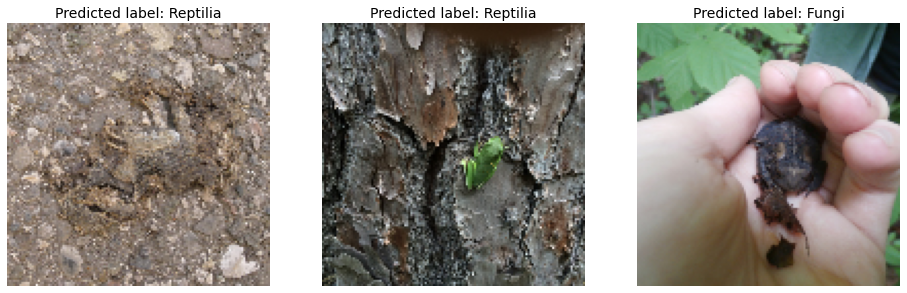




True Label :Animalia



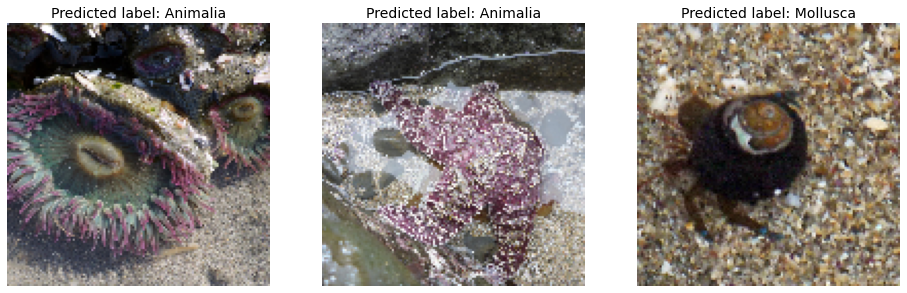




True Label :Arachnida



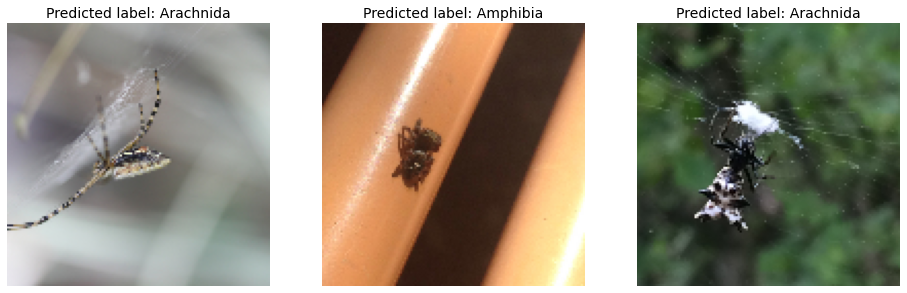




True Label :Aves



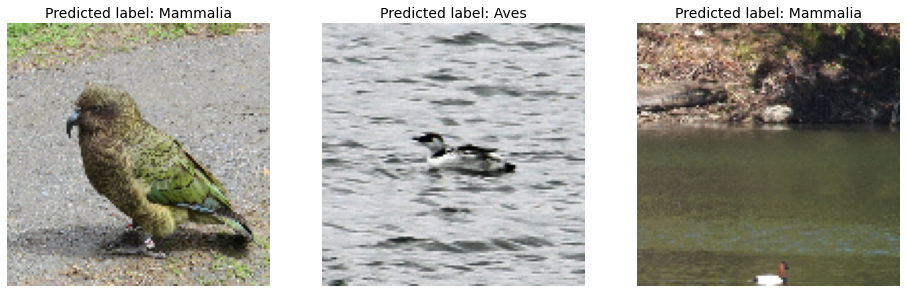




True Label :Fungi



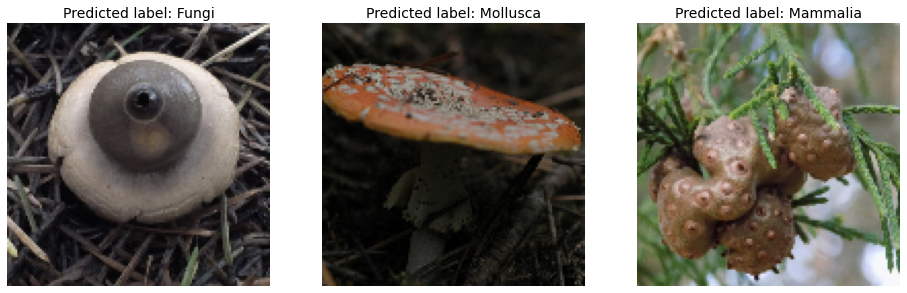




True Label :Insecta



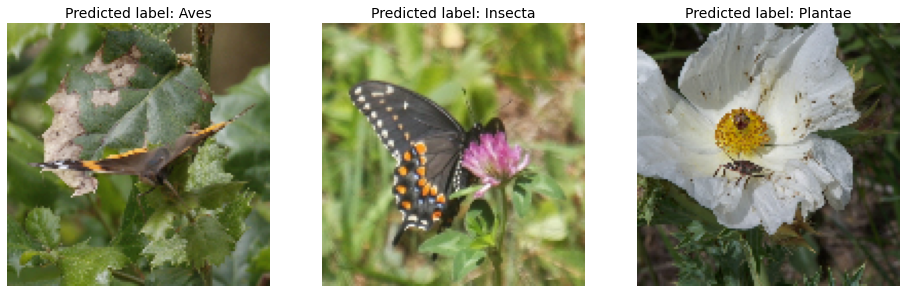




True Label :Mammalia



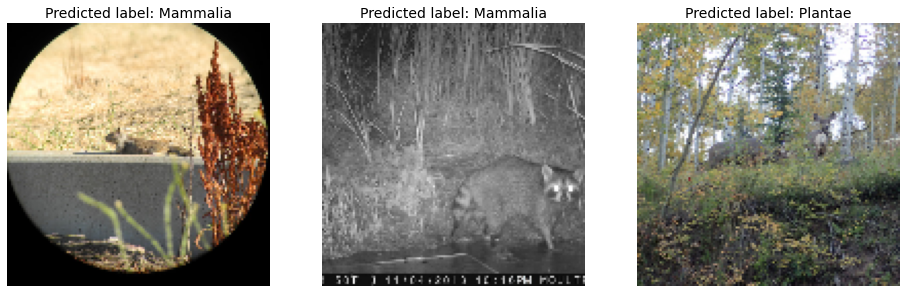




True Label :Mollusca



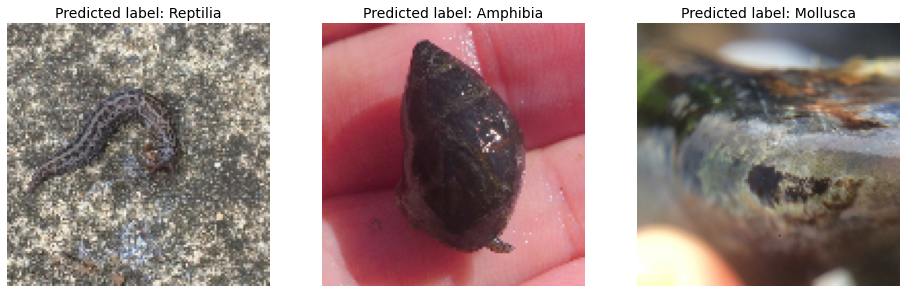




True Label :Plantae



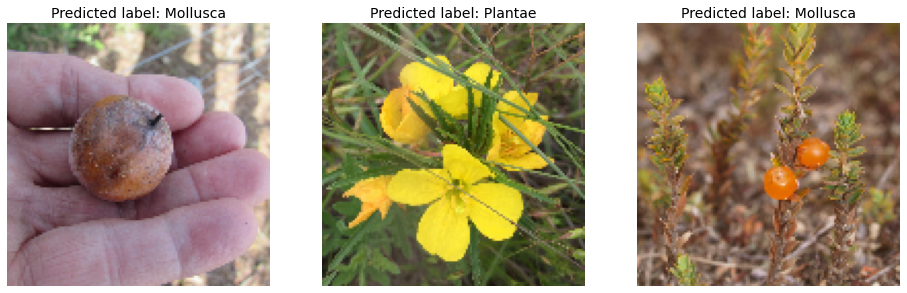




True Label :Reptilia



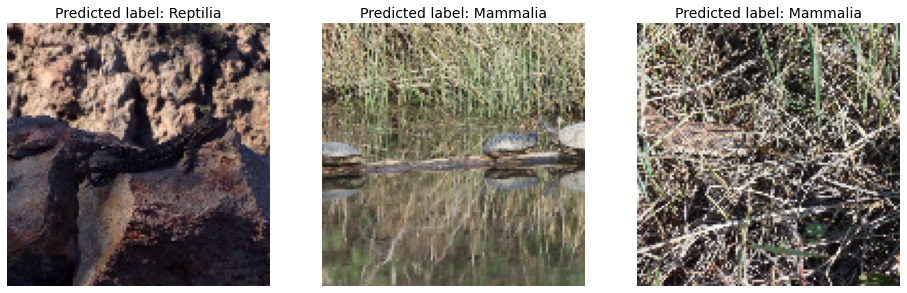

In [ ]:
# Retrieve class names in alphabetical order
input_image_shape = (128,128,3)
#Get class names
class_names_dict = test_gen.class_indices
class_names = class_names_dict.keys()

index_to_name = dict([(class_names_dict[key], key) for key in class_names_dict])

sample_images = []
#Find 3 sample images per class
for class_name in class_names:
    num_test_images = len(os.listdir("/content/inaturalist_12K/val/"+class_name))
    test_images = os.listdir("/content/inaturalist_12K/val/"+class_name)
    random_indices = np.random.randint(0, num_test_images, 3)
    print(f"\n\n\nTrue Label :{class_name}\n")

    plt.figure(figsize=(16, 5))
    for i, ind in enumerate(random_indices):

        image = plt.imread("/content/inaturalist_12K/val/"+class_name+"/"+test_images[ind])
        # Resize input image to the model input shape
        resized_image = tf.keras.preprocessing.image.smart_resize(image, input_image_shape[:2])/255.0
        # Predict the class
        pred = np.argmax(model.predict(np.array([resized_image])), axis=-1)[0]
        
        # Convert the index to the class label
        predicted_class = index_to_name[pred]
        plt.subplot(1, 3, i+1)
        plt.imshow(resized_image)
        plt.axis("off")
        plt.title(f"Predicted label: {predicted_class}", size=14)
    wandb.log({f"True Label: {class_name}": plt})
    plt.show()

## Question 4 c]: Visualise all the filters in the first layer of your best model for a random image from the test set. If there are 64 filters in the first layer plot them in an 8 x 8 grid. 

The first layer of the best model has 16 filters. The visualization of the same is as follows:

In [27]:
wandb.init(project="Assignment_2", entity="hithesh-sidhesh", name="Question_1_part_d")

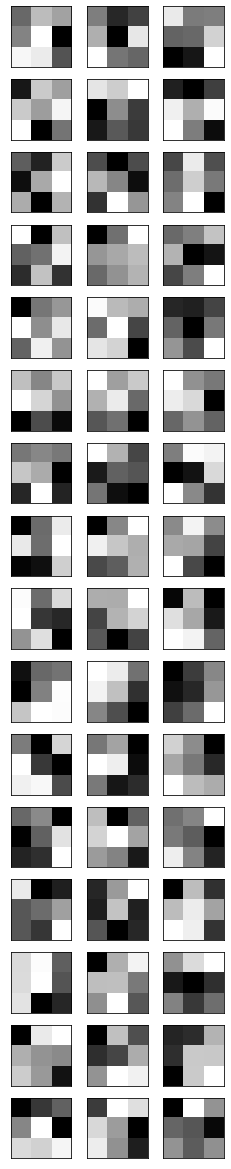

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15_input (InputLayer  [(None, 128, 128, 3)]    0         
 )                                                               
                                                                 
 conv2d_15 (Conv2D)          (None, 126, 126, 16)      448       
                                                                 
Total params: 448
Trainable params: 448
Non-trainable params: 0
_________________________________________________________________
Found 2000 images belonging to 10 classes.


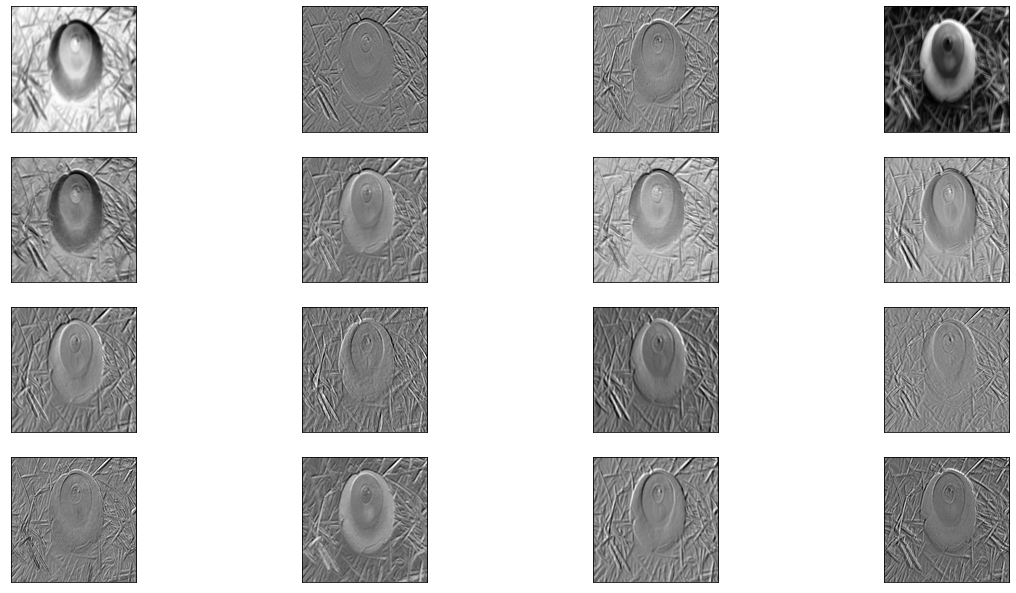

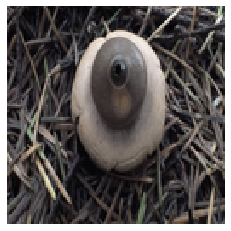

In [32]:
from matplotlib.pyplot import figure

# Plotting neuron

def plotGrid(images, n_row, n_col):
 
	f, axarr = plt.subplots(n_row,n_col, sharex='col', sharey='row', figsize=(40,40))
	plt.subplots_adjust(bottom=0.3, top=0.7, hspace=0.2, right = 0.2)
	k = 0
	# Plotting 4*4 subplot of images of different labels
	for i in range(0,n_row):
		for j in range(0,n_col):
			axarr[i,j].imshow(images[:, :, :, i][:, :, j], cmap='gray')
			axarr[i,j].set_xticks([])
			axarr[i,j].set_yticks([])
			k += 1
		

	#wandb.log({f"Filters": plt})
	plt.show()
 


# Retrieve weight values from the layer 0
filters, biases = model.layers[0].get_weights()

# Add filters along depth dimension
#filters = np.sum(filters, axis = 0)

# Normalize filter values between 0 to 1
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

# plot the filters in a grid
plotGrid(filters, 16, 3)

first_layer = tf.keras.Model(inputs=model.inputs, outputs=model.layers[0].output)
first_layer.summary()
#%%
import random

datagen = ImageDataGenerator()
test_iterator = datagen.flow_from_directory('/content/inaturalist_12K/val/', batch_size=32,
                                            target_size=(128, 128),
                                            interpolation='lanczos')


batchX, batchy = test_iterator.next()
sample = batchX[random.randint(0, len(batchX))]
sample = np.expand_dims(sample, axis=0)
out = first_layer.predict(sample)


f, axarr = plt.subplots(4,4, sharex='col', sharey='row', figsize=(20,20))
plt.subplots_adjust(bottom=0.3, top=0.7, hspace=0.2)
k = 1
# Plotting 4*4 subplot of images of different labels
for i in range(0,4):
	for j in range(0,4):
		axarr[i,j].imshow(out[0, :, :, k-1], cmap=plt.cm.gray)
		axarr[i,j].set_xticks([])
		axarr[i,j].set_yticks([])
		k += 1

#wandb.log({f"Feature Maps": plt})
plt.show()


plt.axis('off')
plt.imshow(sample[0].astype(np.uint8), interpolation='nearest')
plt.show()

In [26]:
wandb.finish()



## Question 5: Apply guided back propagation 

Guided backpropogation on any 10 neurons in the CONV5 layer and plot the images which excite this neuron. The idea again is to discover interesting patterns which excite some neurons. You will draw a 10 x 1 grid below with one image for each of the 10 neurons. 



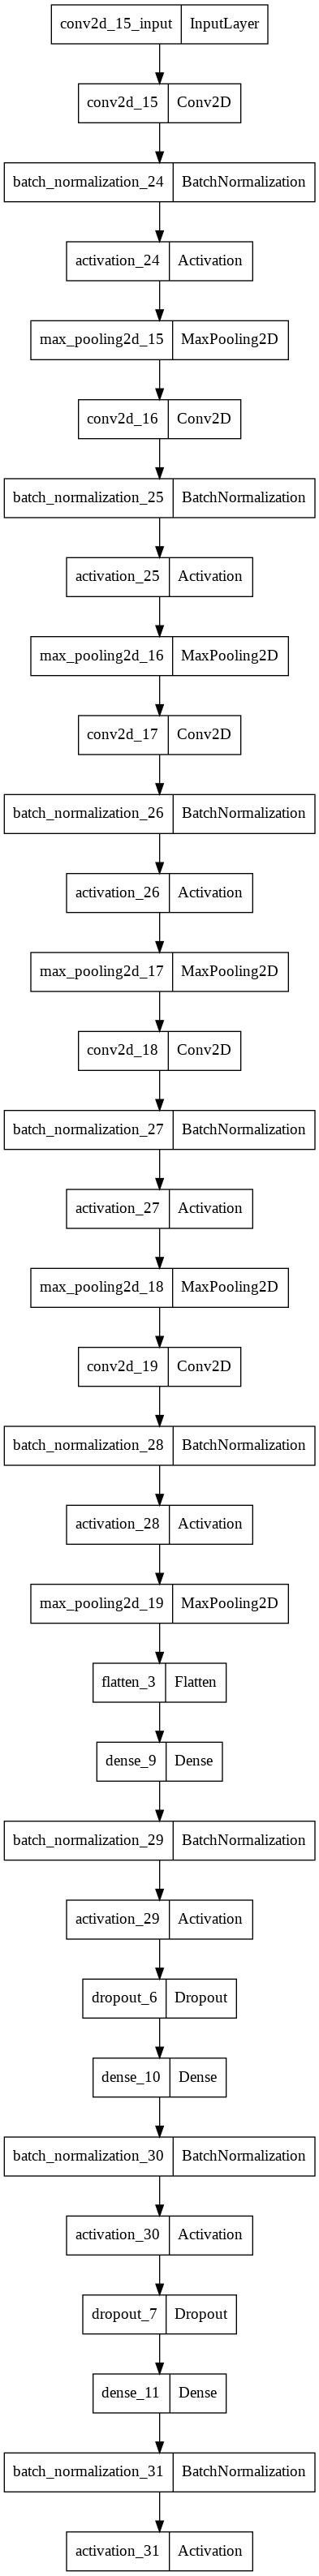

In [7]:
from keras.utils.vis_utils import plot_model

plot_model(model)

In [23]:
from tensorflow.keras.models import Model

#Reference: 
#https://colab.research.google.com/drive/17tAC7xx2IJxjK700bdaLatTVeDA02GJn?usp=sharing#scrollTo=jgTRCYgX4oz-
#https://localcoder.org/how-to-apply-guided-backprop-in-tensorflow-2-0

@tf.custom_gradient
def guidedRelu(x):
  def grad(dy):
    return tf.cast(dy>0,"float32") * tf.cast(x>0, "float32") * dy
  return tf.nn.relu(x), grad

gb = Model(
    inputs = [model.inputs],
    outputs = [model.get_layer(index = -16).output]
)

layer_dict = [layer for layer in gb.layers[1:] if hasattr(layer,'activation')]           
for layer in layer_dict:
  if layer.activation == tf.keras.activations.relu:
    layer.activation = guidedRelu


In [28]:
def deprocess_image(x):
    """Same normalization as in https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py"""
    
    # normalize tensor: center on 0., ensure std is 0.25
    x = x.copy()
    x -= x.mean()
    x /= (x.std() + tf.keras.backend.epsilon())
    x *= 0.25

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if tf.keras.backend.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

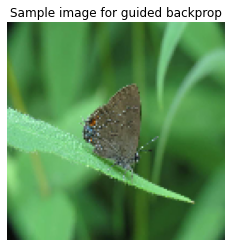

In [54]:
# Selecting random image from dataset
class_name = os.listdir("/content/inaturalist_12K/train")[np.random.randint(0, 10)]
image_name = os.listdir("/content/inaturalist_12K/train/"+class_name)
random_image = image_name[np.random.randint(0, len(image_name))]
img3 = tf.keras.preprocessing.image.load_img("/content/inaturalist_12K/train/"+class_name+"/"+random_image,
                                            target_size=(128, 128))

# Plot image
plt.imshow(img3)
plt.axis("off")
plt.title("Sample image for guided backprop")
plt.show()


In [55]:
img4 = tf.keras.preprocessing.image.img_to_array(img3)/255.0

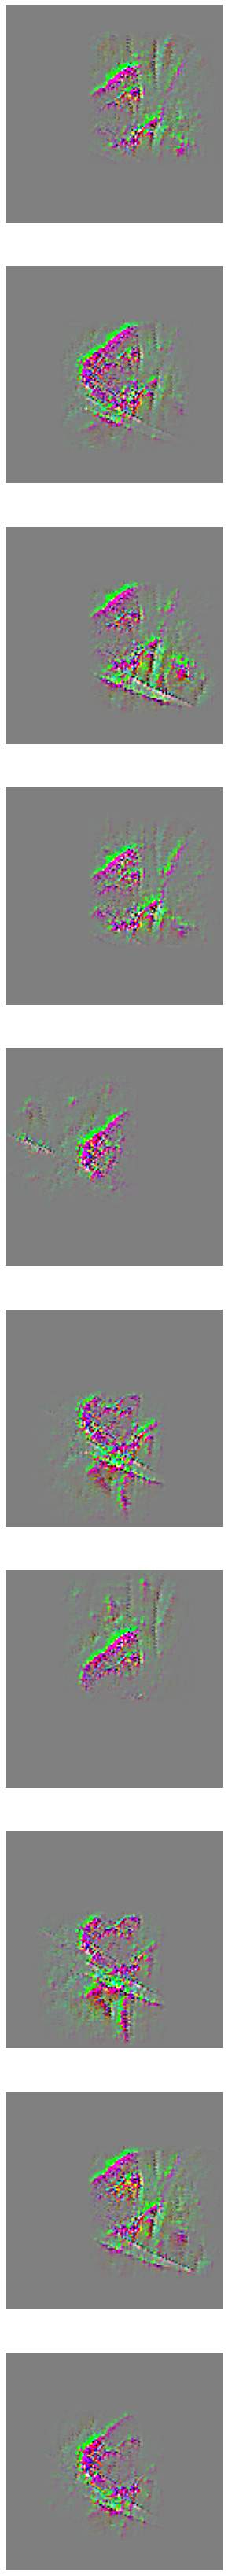

In [57]:

# Shape of the last conv layer
conv_output_shape = model.layers[-16].output.shape[1:]

plt.figure(figsize=(30, 60))
for i in range(10):
    # Index of a random pixel
    node_x = np.random.randint(0, conv_output_shape[0])

    node_y = np.random.randint(0, conv_output_shape[1])

    node_z = np.random.randint(0, conv_output_shape[2])

    # Focus on single neuron of the conv layer (mask for this)
    mask = np.zeros((1, *conv_output_shape), dtype="float")
    mask[0, node_x, node_y, node_z] = 1

    # Compute gradients
    with tf.GradientTape() as tape:
        inputs = tf.cast(np.array([np.array(img4)]), tf.float32)
        tape.watch(inputs)
        outputs = gb(inputs) * mask

    grads = tape.gradient(outputs, inputs)[0]

    # Visualize the output of guided backpropagation
    img_gb = np.dstack((grads[:, :, 0], grads[:, :, 1], grads[:, :, 2],)) 

    plt.subplot(10, 1, i+1)
    plt.imshow(deprocess_image(img_gb))
    plt.axis("off")

plt.show()